# Embedding text column(s)

In [1]:
# import packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split # scikit-learn
from sklearn.cluster import KMeans
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
#from sklearn.metrics import mean_squared_error, r2_score
from collections import Counter
import wordcloud
from sklearn.linear_model import LinearRegression
from sklearn.metrics import silhouette_score

import umap.umap_ as umap

/work/datascience_exam/env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [52]:
# load test dataset
train = pd.read_csv('/work/datascience_exam/data/train.csv', index_col=0)

In [53]:
# divide data into X and y (train)
X_train = train.iloc[:,:4].values # all rows, column 1 to (not incl) 4
y_train = train.iloc[:,4].values # all rows, column 4

In [9]:
X_train.shape

(515049, 4)

In [10]:
y_train.shape

(515049,)

## Embedding 'Country' using sbert 

In [4]:
# choose model
model = SentenceTransformer("all-MiniLM-L6-v2")

/work/datascience_exam/env/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [5]:
# country
X_train[:,1]

array(['Germany',
       'United States of America; Soviet Union; Russian Empire', 'Canada',
       ..., 'Germany', 'United States of America',
       'United Kingdom of Great Britain and Ireland'], dtype=object)

In [6]:
#columns_to_embed = ['Country']#, 'column1']  # Change this to your actual column names
# sentences need to be in list format 
country = X_train[:,1].tolist()

In [7]:
country_embeddings = model.encode(country)

In [8]:
country_embeddings.shape

(515049, 384)

### Reducing the dimensionalities of 'Country' embeddings

In [34]:
pca = PCA(n_components= 250, random_state=42)
pca_vecs = pca.fit_transform(country_embeddings)

explained_variance = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance)

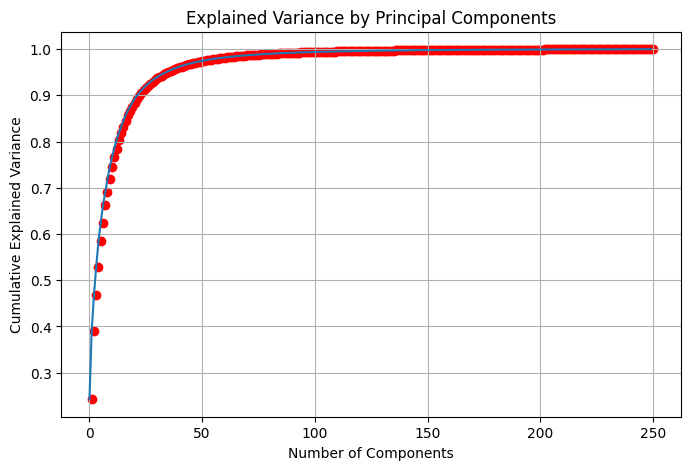

In [35]:
plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(explained_variance))
plt.scatter(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, color='r')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Principal Components')
plt.grid(True)
plt.show()

In [36]:
threshold = 0.95
num_components = np.argmax(cumulative_explained_variance >= threshold) + 1
print(f"Number of components needed to explain {threshold*100}% variance: {num_components}")


Number of components needed to explain 95.0% variance: 36


In [37]:

def dimension_reduction_comp(embedded_data, components, X_train_data):
    total_variance_explained = []

    pca = PCA(n_components=components, random_state=42)

    pca_vecs = pca.fit_transform(embedded_data)

    explained_variance = pca.explained_variance_ratio_
    
    # Calculate the total variance explained by the specified number of components
    total_variance_explained = np.sum(explained_variance) * 100
    print(f"Total variance explained by the first {components} components: {total_variance_explained:.2f}%")

    #X_train_w_pca_vecs =np.empty(shape = (515049, 1))
    full_data = np.hstack((X_train_data, pca_vecs))
    
    return(full_data, pca_vecs)

In [38]:
X_train_country_pca, pca_vecs_country = dimension_reduction_comp(country_embeddings, 36, X_train)

Total variance explained by the first 36 components: 95.22%


In [43]:
pca_vecs_country.shape

(515049, 36)

### Clustering 'Country' embeddings

/tmp/ipykernel_12735/2275316567.py:10: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo-" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(K, inertia, 'bo-', marker='o')


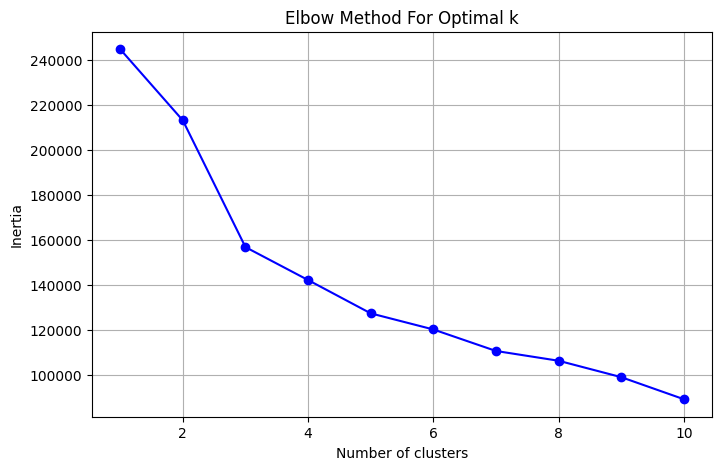

In [44]:
# Elbow Method to find the optimal number of clusters
inertia = []
K = range(1, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42).fit(pca_vecs_country)
    inertia.append(kmeans.inertia_)

# Plotting the results
plt.figure(figsize=(8, 5))
plt.plot(K, inertia, 'bo-', marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.grid(True)
plt.show()

In [45]:
# sample dataset (or reduce number of rows for testing code)
embed_subset = pca_vecs_country[:10000,:]
embed_subset.shape


(10000, 36)

/tmp/ipykernel_12735/2620205839.py:11: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo-" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(K, silhouette_avg, 'bo-', marker='o')


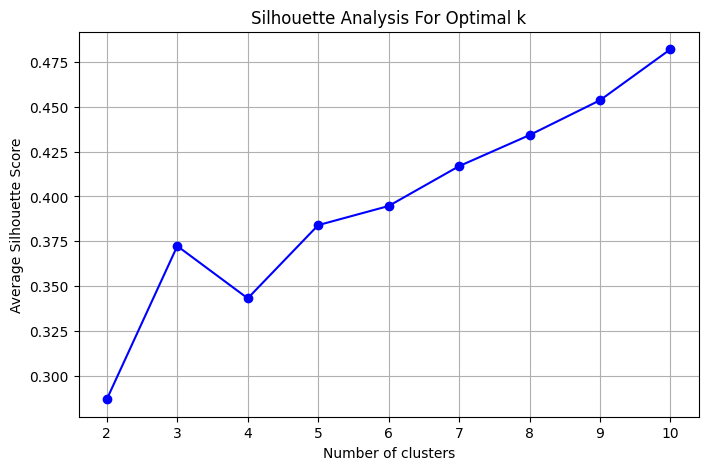

In [46]:
# Silhouette Analysis to find the optimal number of clusters
silhouette_avg = []
K = range(2, 11)  # Silhouette score is not defined for k=1
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42).fit(embed_subset)
    cluster_labels = kmeans.labels_
    silhouette_avg.append(silhouette_score(embed_subset, cluster_labels))

# Plotting the results
plt.figure(figsize=(8, 5))
plt.plot(K, silhouette_avg, 'bo-', marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Average Silhouette Score')
plt.title('Silhouette Analysis For Optimal k')
plt.grid(True)
plt.show()

In [62]:
# MAYBE MAKE THIS PANDAS FRIENDLY AND ALSO FRIENDLY TO INCLUDE OCCUPATION CLUSTERS NEXT

def clustering(embedded_data, n_clusters, X_train_data):
    X_train_w_clusters_temp = []

    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(embedded_data)

    clusters = kmeans.labels_
    X_train_w_clusters_temp =  np.hstack((X_train_data, clusters.reshape(-1,1)))

    return(X_train_w_clusters_temp)


In [64]:
# call function
X_train_w_clusters = clustering(pca_vecs_country, 7, X_train)


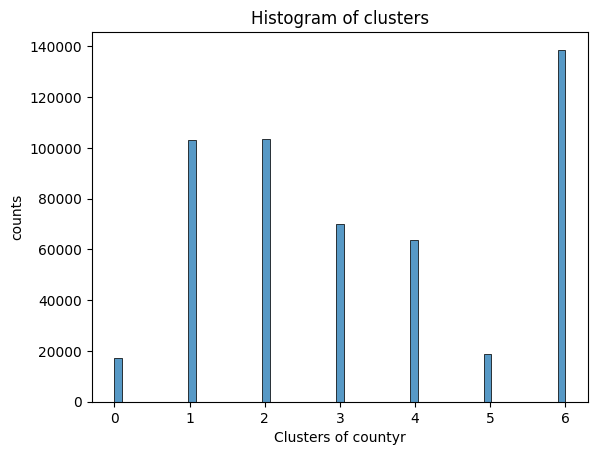

In [66]:
sns.histplot(X_train_w_clusters[:,4])
plt.xlabel('Clusters of countyr')
plt.ylabel('counts')
plt.title('Histogram of clusters')
#plt.xticks([0,1,2,3,4,5])
plt.show()

Now we want to check the sanity of our clusters by making wordclouds.

In [67]:
# Wordcloud function

def wordcloud_of_cluster(clustered_data, cluster_no, feature):
    # filter cluster no
    cluster = clustered_data[clustered_data[:, 4] == cluster_no]
    
    # 
    cluster_pd = pd.DataFrame(cluster, columns=['idx', 'Country', 'Occupation', 'Birth_year', 'cluster_no'])
    word_list = [word.strip() for sublist in cluster_pd[feature].str.split(';') for word in sublist]
    count = Counter(word_list)

    return(count)

In [ ]:
# for later # save wordcloud
#wordcloud_country.to_file("/work/datascience_exam/output/plots/wordcloud_country.png") 

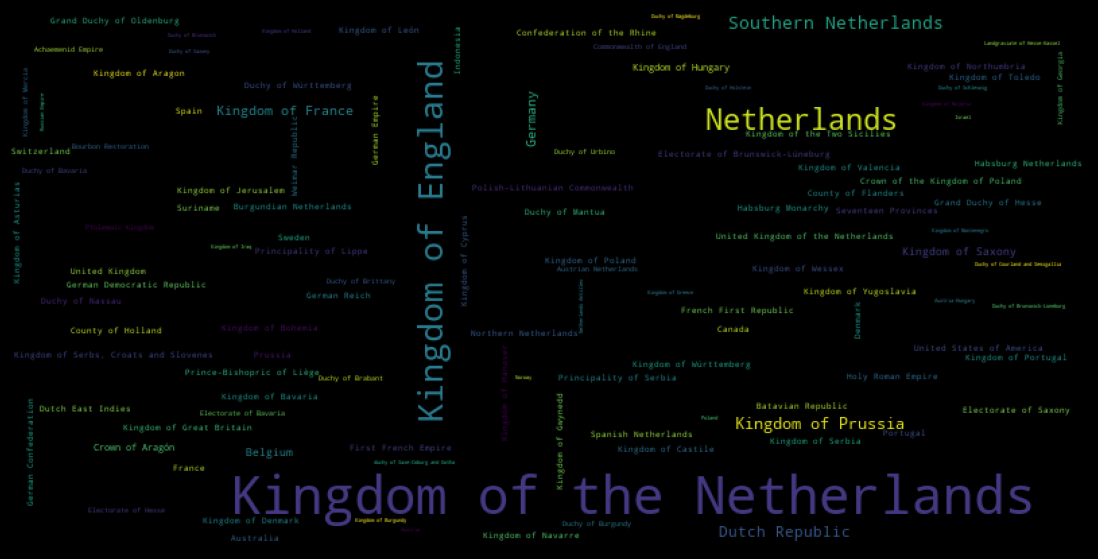

[('Kingdom of the Netherlands', 9827),
 ('Kingdom of England', 3007),
 ('Netherlands', 2322),
 ('Southern Netherlands', 382),
 ('Kingdom of Prussia', 317),
 ('Dutch Republic', 244),
 ('Kingdom of France', 193),
 ('Germany', 180),
 ('Belgium', 95),
 ('Kingdom of Saxony', 94),
 ('Kingdom of Hungary', 72),
 ('Crown of Aragón', 63),
 ('Kingdom of Bavaria', 53),
 ('United States of America', 52),
 ('Kingdom of Hanover', 46),
 ('Kingdom of Württemberg', 42),
 ('German Empire', 42),
 ('Kingdom of Poland', 38),
 ('Kingdom of Castile', 32),
 ('Kingdom of Serbia', 31)]

In [69]:
count = wordcloud_of_cluster(X_train_w_clusters, 0, 'Country')

wordcloud_temp = wordcloud.WordCloud(width=800, height=400).generate_from_frequencies(count)
plt.figure( figsize=(15,7), facecolor = 'k')

plt.imshow(wordcloud_temp)#, interpolation='bilinear')
plt.axis("off")
plt.show()
count.most_common(20)

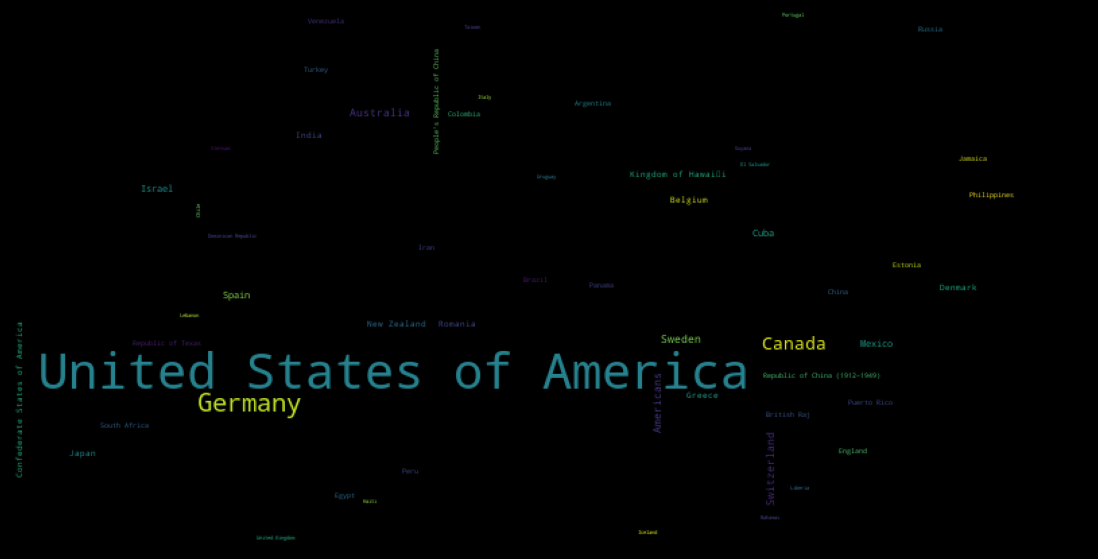

[('United States of America', 102967),
 ('Germany', 521),
 ('Canada', 209),
 ('Switzerland', 57),
 ('Sweden', 55),
 ('Australia', 51),
 ('Americans', 50),
 ('Israel', 40),
 ('Mexico', 39),
 ('Cuba', 36),
 ('Spain', 36),
 ('Confederate States of America', 29),
 ('Denmark', 29),
 ('Kingdom of Hawaiʻi', 25),
 ('Greece', 21),
 ('Japan', 20),
 ('New Zealand', 19),
 ('Belgium', 18),
 ('India', 17),
 ('Romania', 16)]

In [70]:
count = wordcloud_of_cluster(X_train_w_clusters, 1, 'Country')

wordcloud_temp = wordcloud.WordCloud(width=800, height=400).generate_from_frequencies(count)
plt.figure( figsize=(15,7), facecolor = 'k')

plt.imshow(wordcloud_temp)#, interpolation='bilinear')
plt.axis("off")
plt.show()
count.most_common(20)

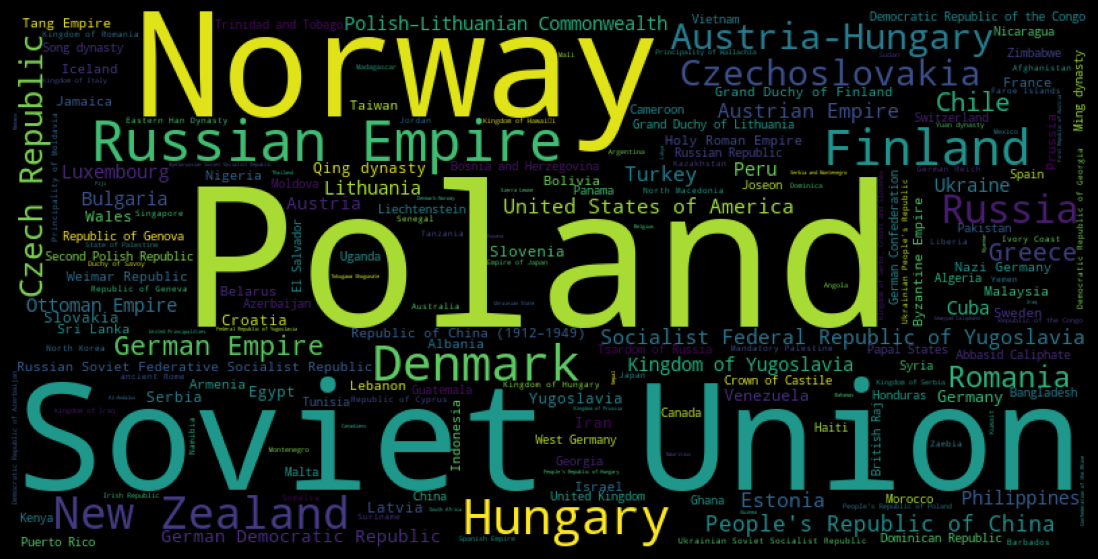

[('Poland', 11184),
 ('Soviet Union', 9981),
 ('Norway', 9747),
 ('Russian Empire', 7911),
 ('Finland', 6095),
 ('Denmark', 5980),
 ('Hungary', 5835),
 ('New Zealand', 4715),
 ('Russia', 3581),
 ('Austria-Hungary', 3181),
 ('Czechoslovakia', 2968),
 ('Czech Republic', 2625),
 ('Romania', 2172),
 ('German Empire', 1852),
 ('Chile', 1757),
 ('Greece', 1483),
 ("People's Republic of China", 1144),
 ('Socialist Federal Republic of Yugoslavia', 1126),
 ('Turkey', 1082),
 ('Estonia', 1074)]

In [71]:
count = wordcloud_of_cluster(X_train_w_clusters, 2, 'Country')

wordcloud_temp = wordcloud.WordCloud(width=800, height=400).generate_from_frequencies(count)
plt.figure( figsize=(15,7), facecolor = 'k')

plt.imshow(wordcloud_temp)#, interpolation='bilinear')
plt.axis("off")
plt.show()
count.most_common(20)

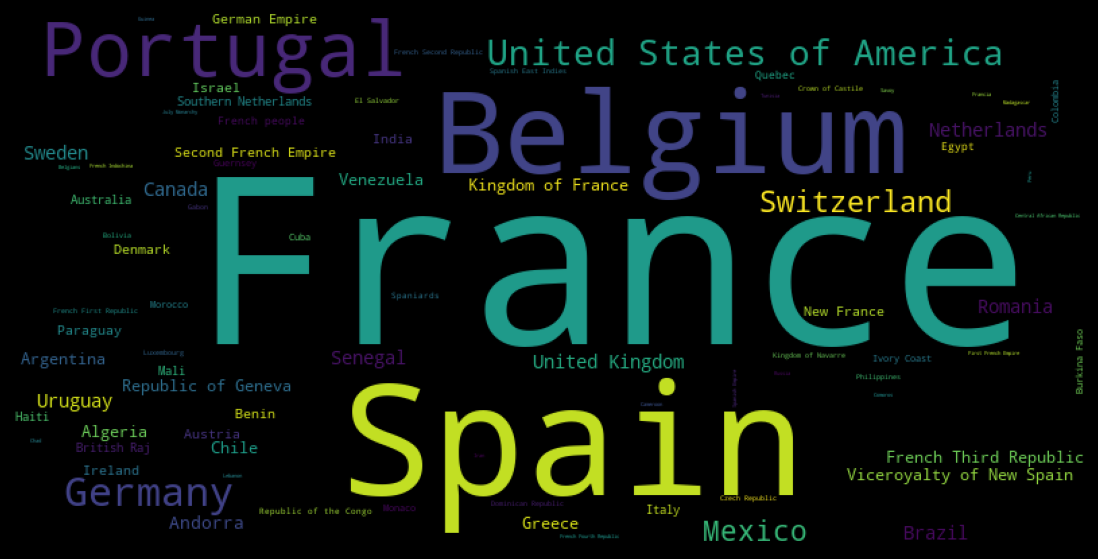

[('France', 46158),
 ('Spain', 14856),
 ('Belgium', 6960),
 ('Portugal', 2281),
 ('Germany', 199),
 ('United States of America', 150),
 ('Switzerland', 108),
 ('Mexico', 97),
 ('Netherlands', 32),
 ('Canada', 31),
 ('Sweden', 31),
 ('Uruguay', 31),
 ('Brazil', 29),
 ('Romania', 28),
 ('United Kingdom', 27),
 ('Senegal', 26),
 ('Andorra', 24),
 ('Argentina', 20),
 ('Kingdom of France', 20),
 ('Chile', 19)]

In [72]:
count = wordcloud_of_cluster(X_train_w_clusters, 3, 'Country')

wordcloud_temp = wordcloud.WordCloud(width=800, height=400).generate_from_frequencies(count)
plt.figure( figsize=(15,7), facecolor = 'k')

plt.imshow(wordcloud_temp)#, interpolation='bilinear')
plt.axis("off")
plt.show()
count.most_common(20)

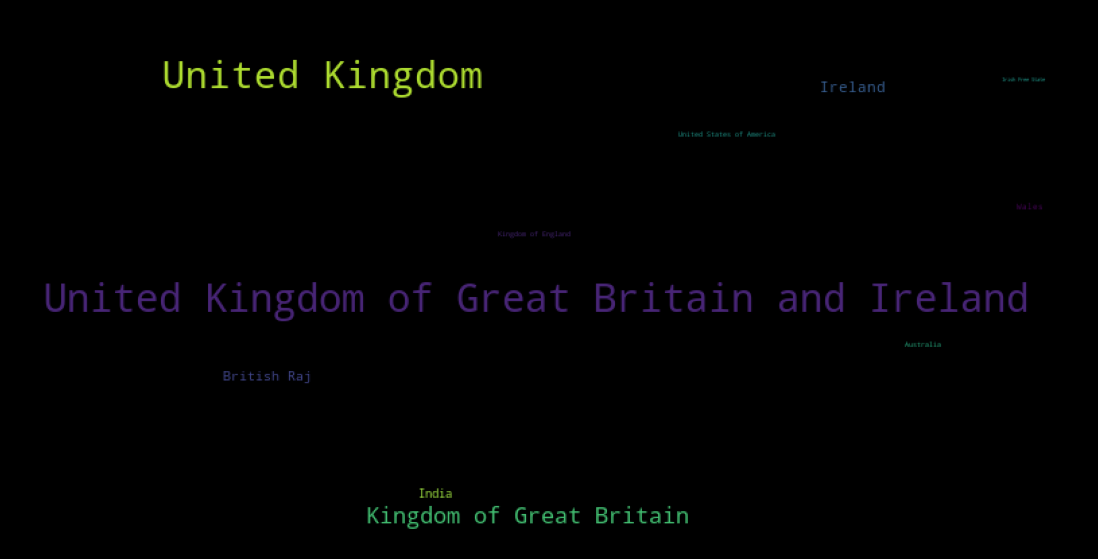

[('United Kingdom of Great Britain and Ireland', 38831),
 ('United Kingdom', 36326),
 ('Kingdom of Great Britain', 8411),
 ('Ireland', 2744),
 ('British Raj', 2460),
 ('India', 2011),
 ('Wales', 866),
 ('Kingdom of England', 585),
 ('Australia', 572),
 ('United States of America', 533),
 ('Irish Free State', 363),
 ('Kingdom of Scotland', 272),
 ('Kingdom of Ireland', 258),
 ('Pakistan', 243),
 ('Canada', 115),
 ('New Zealand', 71),
 ('Irish Republic', 59),
 ('England', 58),
 ('British people', 58),
 ('Germany', 58)]

In [73]:
count = wordcloud_of_cluster(X_train_w_clusters, 4, 'Country')

wordcloud_temp = wordcloud.WordCloud(width=800, height=400).generate_from_frequencies(count)
plt.figure( figsize=(15,7), facecolor = 'k')

plt.imshow(wordcloud_temp)#, interpolation='bilinear')
plt.axis("off")
plt.show()
count.most_common(20)

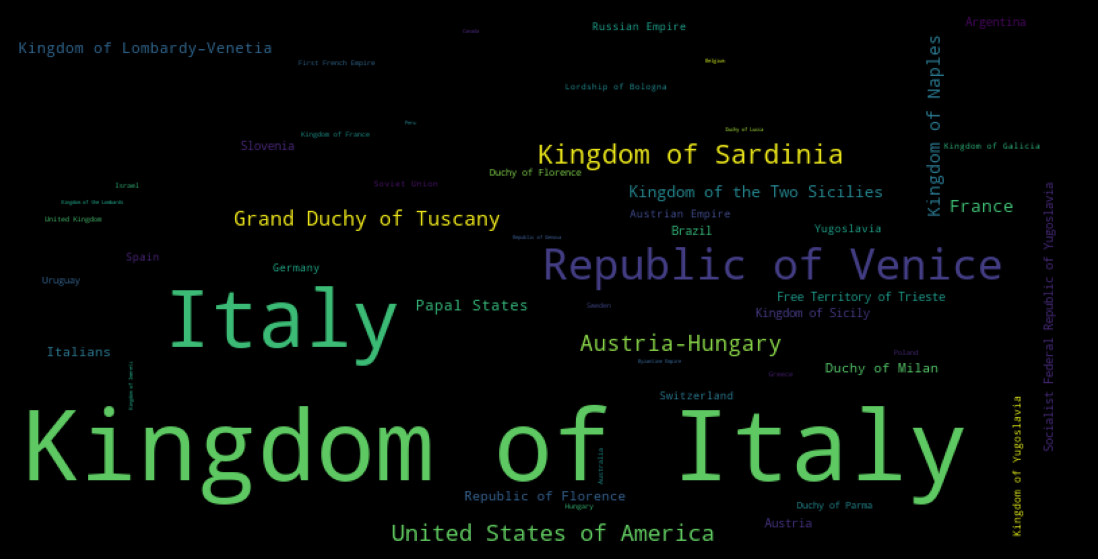

[('Kingdom of Italy', 17582),
 ('Italy', 10978),
 ('Republic of Venice', 807),
 ('Kingdom of Sardinia', 193),
 ('United States of America', 142),
 ('Austria-Hungary', 123),
 ('Grand Duchy of Tuscany', 105),
 ('Kingdom of Naples', 83),
 ('France', 81),
 ('Kingdom of the Two Sicilies', 66),
 ('Kingdom of Lombardy–Venetia', 57),
 ('Papal States', 57),
 ('Republic of Florence', 43),
 ('Duchy of Milan', 42),
 ('Italians', 39),
 ('Socialist Federal Republic of Yugoslavia', 35),
 ('Free Territory of Trieste', 34),
 ('Austria', 32),
 ('Argentina', 30),
 ('Kingdom of Sicily', 28)]

In [74]:
count = wordcloud_of_cluster(X_train_w_clusters, 5, 'Country')

wordcloud_temp = wordcloud.WordCloud(width=800, height=400).generate_from_frequencies(count)
plt.figure( figsize=(15,7), facecolor = 'k')

plt.imshow(wordcloud_temp)#, interpolation='bilinear')
plt.axis("off")
plt.show()
count.most_common(20)

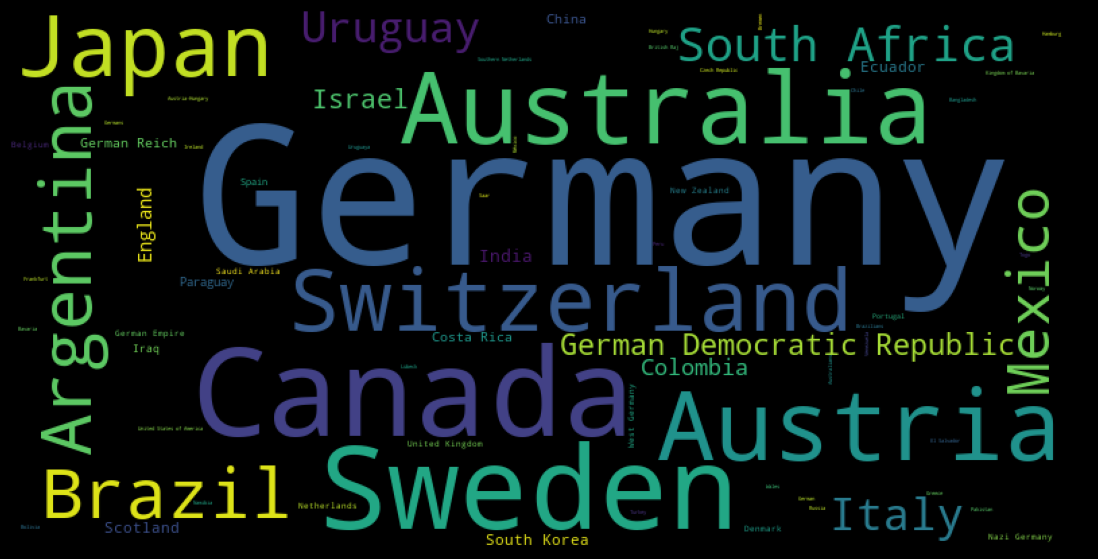

[('Germany', 57588),
 ('Canada', 14870),
 ('Sweden', 13123),
 ('Australia', 9582),
 ('Austria', 9114),
 ('Switzerland', 6743),
 ('Japan', 6711),
 ('Argentina', 4373),
 ('Brazil', 4218),
 ('Mexico', 2844),
 ('South Africa', 1848),
 ('Italy', 1591),
 ('Uruguay', 1541),
 ('German Democratic Republic', 1277),
 ('Israel', 1101),
 ('Colombia', 788),
 ('England', 551),
 ('India', 493),
 ('Scotland', 367),
 ('Ecuador', 360)]

In [75]:
count = wordcloud_of_cluster(X_train_w_clusters, 6, 'Country')

wordcloud_temp = wordcloud.WordCloud(width=800, height=400).generate_from_frequencies(count)
plt.figure( figsize=(15,7), facecolor = 'k')

plt.imshow(wordcloud_temp)#, interpolation='bilinear')
plt.axis("off")
plt.show()
count.most_common(20)

These clusters might not make a lot of sense in that so countries can be found in all the wordclouds; but that is because the wordclouds are made based on each string not taking into account that some of the rows might contain multiple strings for 'Country'. 

In [ ]:
# transform to pandas dataframe so that we can include column names 
gender = pd.DataFrame(X_train_country_pca[:,0], columns='gender')
birth_year = pd.DataFrame(X_train_country_pca[:,3], columns = 'birth_year')



In [82]:
pca_vecs_country.shape

(515049, 36)

In [80]:
X_train_country_pca[:,3:7]

array([[1802, 3, -0.35003960132598877, -0.14536742866039276],
       [1884, 5, 0.27439746260643005, 0.06368104368448257],
       [1896, 3, -0.014992311596870422, -0.18164439499378204],
       ...,
       [1876, 3, -0.35003307461738586, -0.14541378617286682],
       [1928, 4, 0.6087554693222046, -0.22489838302135468],
       [1860, 2, 0.2648048996925354, 0.6880903244018555]], dtype=object)

## Embedding 'Occupation' using sbert sentencetransformer 

In [11]:
# choose model
model_sbert = SentenceTransformer("all-MiniLM-L6-v2")

/work/datascience_exam/env/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [12]:
X_train[:,2] # occupation 

array(['religious figure', 'artist', 'politician', ..., 'artist',
       'politician', 'athlete'], dtype=object)

In [13]:
occupation_list = X_train[:,2].tolist()

In [14]:
len(occupation_list)

515049

In [15]:
occupation_embeddings = model_sbert.encode(occupation_list) 
# save embeddings...

In [14]:
#saving embeddings
#occupation_embeddings_pd = pd.DataFrame(occupation_embeddings)
#occupation_embeddings_pd.to_csv('/work/datascience_exam/data/occupation_embeddings.csv')

### Clustering 'Occupation'

/tmp/ipykernel_1121/2003847804.py:10: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo-" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(K, inertia, 'bo-', marker='o')


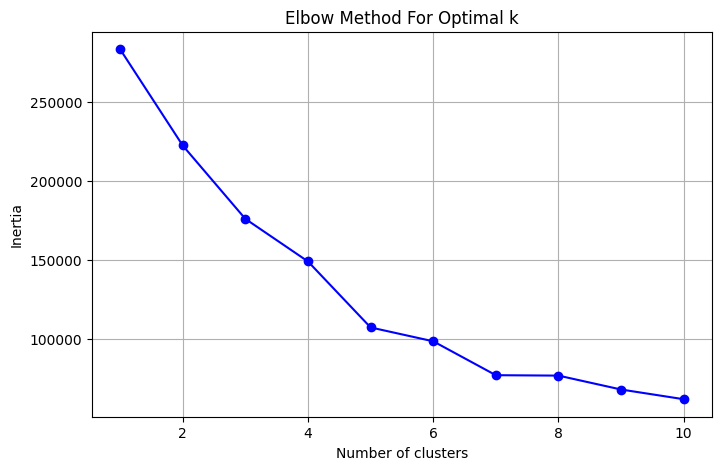

In [13]:

# Elbow Method to find the optimal number of clusters
inertia = []
K = range(1, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42).fit(occupation_embeddings)
    inertia.append(kmeans.inertia_)

# Plotting the results
plt.figure(figsize=(8, 5))
plt.plot(K, inertia, 'bo-', marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.grid(True)
plt.show()

In [14]:
# sample dataset (or reduce number of rows for testing code)
embed_subset = occupation_embeddings[:10000,:]
embed_subset.shape


(10000, 384)

/tmp/ipykernel_1121/1226797528.py:13: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo-" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(K, silhouette_avg, 'bo-', marker='o')


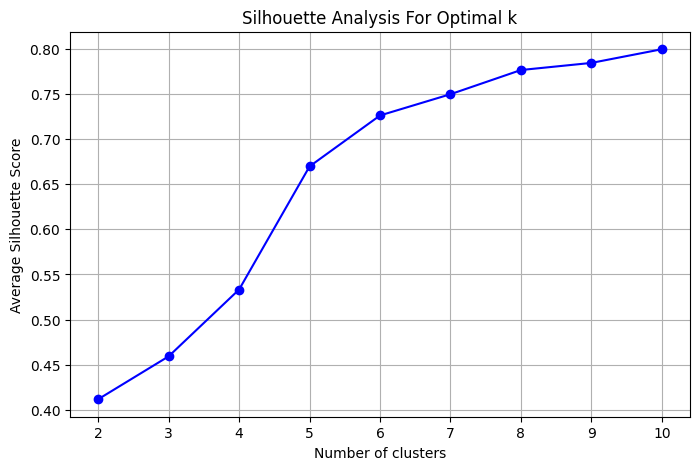

In [15]:
from sklearn.metrics import silhouette_score

# Silhouette Analysis to find the optimal number of clusters
silhouette_avg = []
K = range(2, 11)  # Silhouette score is not defined for k=1
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42).fit(embed_subset)
    cluster_labels = kmeans.labels_
    silhouette_avg.append(silhouette_score(embed_subset, cluster_labels))

# Plotting the results
plt.figure(figsize=(8, 5))
plt.plot(K, silhouette_avg, 'bo-', marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Average Silhouette Score')
plt.title('Silhouette Analysis For Optimal k')
plt.grid(True)
plt.show()


In [11]:
#from sklearn.cluster import KMeans

def clustering(embedded_data, n_clusters, X_train_data):
    X_train_w_clusters = []

    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(embedded_data)

    clusters = kmeans.labels_
    X_train_w_clusters =  np.hstack((X_train_data, clusters.reshape(-1,1)))

    return(X_train_w_clusters)


In [12]:
X_train_w_clusters = clustering(occupation_embeddings, 6, X_train)
X_train_w_clusters.shape

(515049, 5)

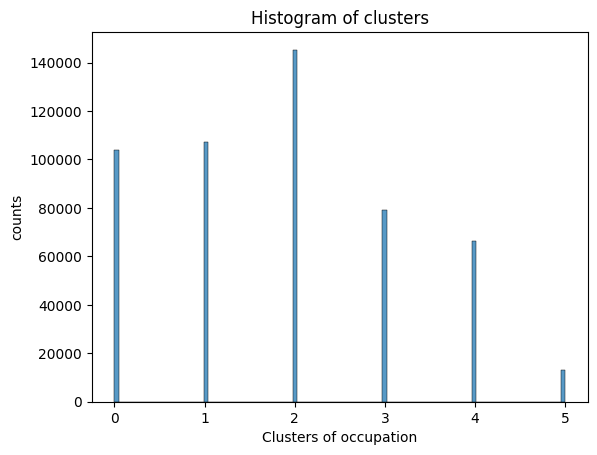

In [13]:
sns.histplot(X_train_w_clusters[:,4])
plt.xlabel('Clusters of occupation')
plt.ylabel('counts')
plt.title('Histogram of clusters')
#plt.xticks([0,1,2,3,4,5])
plt.show()

In [14]:
# Wordcloud function

def wordcloud_of_cluster(clustered_data, cluster_no):
    # filter cluster no
    cluster = clustered_data[clustered_data[:, 4] == cluster_no]
    
    # 
    cluster_pd = pd.DataFrame(cluster, columns=['idx', 'Country', 'Occupation', 'Birth_year', 'cluster_no'])
    word_list = [word.strip() for sublist in cluster_pd['Occupation'].str.split(';') for word in sublist]
    count = Counter(word_list)

    return(count)

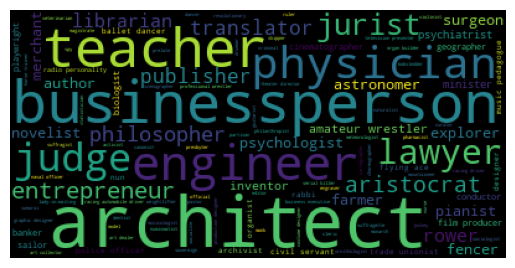

In [15]:
count = wordcloud_of_cluster(X_train_w_clusters, 0)
#count.most_common(20)
wordcloud_temp = wordcloud.WordCloud().generate_from_frequencies(count)
plt.imshow(wordcloud_temp)#, interpolation='bilinear')
plt.axis("off")
plt.show()

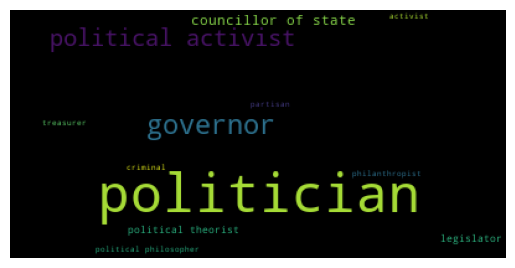

In [16]:
count = wordcloud_of_cluster(X_train_w_clusters, 1)

wordcloud_temp = wordcloud.WordCloud().generate_from_frequencies(count)
plt.imshow(wordcloud_temp)#, interpolation='bilinear')
plt.axis("off")
plt.show()

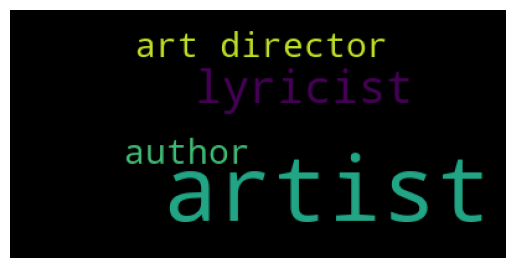

In [17]:
count = wordcloud_of_cluster(X_train_w_clusters, 2)

wordcloud_temp = wordcloud.WordCloud().generate_from_frequencies(count)
plt.imshow(wordcloud_temp)#, interpolation='bilinear')
plt.axis("off")
plt.show()

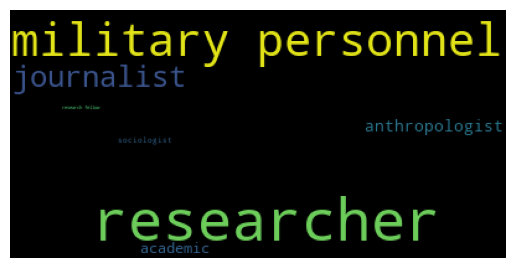

In [18]:
count = wordcloud_of_cluster(X_train_w_clusters, 3)

wordcloud_temp = wordcloud.WordCloud().generate_from_frequencies(count)
plt.imshow(wordcloud_temp)#, interpolation='bilinear')
plt.axis("off")
plt.show()

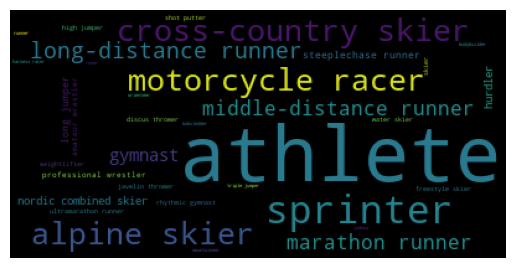

In [19]:
count = wordcloud_of_cluster(X_train_w_clusters, 4)

wordcloud_temp = wordcloud.WordCloud().generate_from_frequencies(count)
plt.imshow(wordcloud_temp)#, interpolation='bilinear')
plt.axis("off")
plt.show()


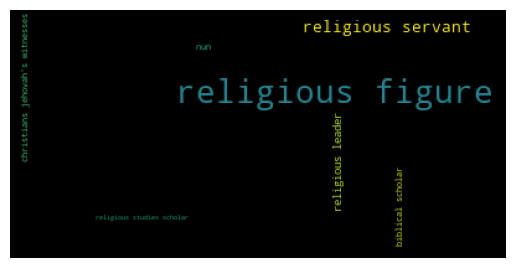

In [20]:
count = wordcloud_of_cluster(X_train_w_clusters, 5)

wordcloud_temp = wordcloud.WordCloud().generate_from_frequencies(count)
plt.imshow(wordcloud_temp)#, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
count = wordcloud_of_cluster(X_train_w_clusters, 6)

wordcloud_temp = wordcloud.WordCloud().generate_from_frequencies(count)
plt.imshow(wordcloud_temp)#, interpolation='bilinear')
plt.axis("off")
plt.show()

### Making UMAP for visualization purposes
Need to do:
- fix plot title
- optimize parameters; n_neighbors and min_dist

In [ ]:
# standardize data first? why? 
umap_reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components = 2)#, random_state = 42) 
# setting a random seed turns of parallelization and subsequently takes much longer to run. for testing, we eon't set a random seed
occupation_umap = umap_reducer.fit_transform(occupation_embeddings)

occupation_umap_pd = pd.DataFrame(occupation_umap)
occupation_umap_pd.to_csv('/work/datascience_exam/data/occupation_umap.csv') # 293 min?? wtf?

In [22]:
# relooad umap UMAP 
occupation_umap = pd.read_csv('/work/datascience_exam/data/occupation_umap.csv', index_col=0)

In [23]:
occupation_umap['cluster'] = X_train_w_clusters[:,4]
occupation_umap.columns = ['feature1', 'feature2', 'cluster']
occupation_umap.head()

,feature1,feature2,cluster
0,3.173786,18.524569,5
1,-8.038143,8.851185,2
2,3.885321,-0.199881,1
3,-6.654826,8.743226,2
4,-7.285582,-13.047606,0


<Figure size 1000x600 with 0 Axes>

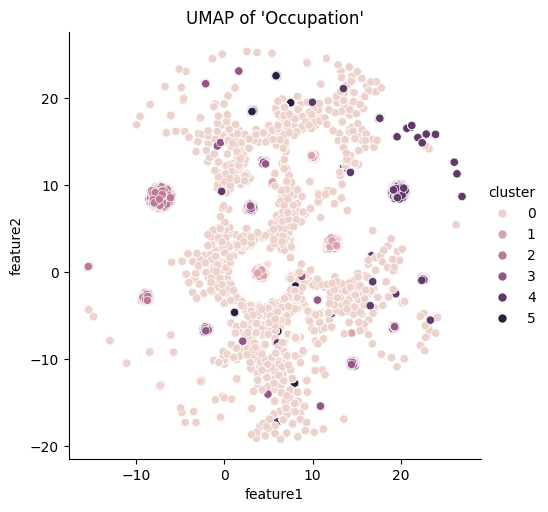

In [24]:
plt.figure(figsize = (10,6))#, constrained_layout = True)
sns.relplot(
    data = occupation_umap, 
    x = 'feature1', y = 'feature2',
    hue = 'cluster'
)

#plt.legend(loc = 'upper left')
plt.title("UMAP of 'Occupation'")#, y = 1.05)#, pad = 20)
#plt.tight_layout() # saves the title but messes up the legend
fig = plt.gcf()
plt.show()

In [25]:
fig.savefig('/work/datascience_exam/output/plots/UMAP_occupation.jpg', dpi = 300)

### Saving data with clusters but without dimension reduction

In [48]:
occupation_embeddings.shape[1]

384

In [29]:
gender = X_train_w_clusters[:,0]
#gender = pd.DataFrame(gender, columns)

In [ ]:
year_cluster = X_train_w_clusters[:,3:5]

In [43]:
big_array = np.hstack((gender.reshape(-1,1), year_cluster, occupation_embeddings))
big_array.shape

(515049, 387)

In [ ]:
# Create list of column names with the format "colN" (from 1 to N)
#col_names = ['occupation' + str(i) for i in np.arange(X_train_predictors.shape[1]) + 1]
colnames_second = ['occupation' + str(i) for i in range(1,occupation_embeddings.shape[1]+1)]

colnames_first = ['gender', 'birth_year', 'occupation_cluster']
colnames = colnames_first + colnames_second
colnames

In [50]:
# turn into pd dataframe
X_train_occupation = pd.DataFrame(big_array, columns = colnames)
X_train_occupation.head()

,gender,birth_year,occupation_cluster,occupation1,occupation2,occupation3,occupation4,occupation5,occupation6,occupation7,...,occupation375,occupation376,occupation377,occupation378,occupation379,occupation380,occupation381,occupation382,occupation383,occupation384
0,1,1802,5,0.013005,0.084847,-0.063246,0.059894,-0.033442,-0.018901,0.120599,...,-0.040293,-0.039761,0.011463,0.062474,-0.049668,-0.058046,0.049507,-0.083734,0.055786,-0.070489
1,2,1884,2,-0.088484,0.041436,0.000193,-0.015857,0.020446,0.040417,0.153976,...,-0.027309,-0.09163,-0.036207,0.085278,-0.032959,0.02629,0.085176,0.018567,0.041372,-0.004208
2,1,1896,1,-0.029719,0.026697,-0.007149,0.022893,-0.020579,0.009408,0.131735,...,-0.006587,-0.06092,0.009801,0.038971,-0.062569,-0.004619,0.075372,-0.014387,0.070478,-0.010214
3,1,1668,2,-0.088484,0.041436,0.000193,-0.015857,0.020446,0.040417,0.153976,...,-0.027309,-0.09163,-0.036207,0.085278,-0.032959,0.02629,0.085176,0.018567,0.041372,-0.004208
4,1,1888,0,-0.038511,0.077164,-0.020035,0.025214,-0.067773,-0.067651,0.025763,...,0.046558,-0.038892,0.049494,-0.06015,-0.05231,-0.024409,0.14008,0.038783,-0.014841,0.026823


In [52]:
X_train_occupation.to_csv('/work/datascience_exam/data/X_train_occupation.csv') # index = False

In [ ]:
#pd.read_csv('/work/datascience_exam/data/X_train_occupation.csv', index_col = 0)

In [ ]:
# another way

# Convert NumPy arrays to pandas DataFrames
df1 = pd.DataFrame(array1, columns=['A', 'B', 'C'])
df2 = pd.DataFrame(array2, columns=['A', 'B', 'C'])
df3 = pd.DataFrame(array3, columns=['A', 'B', 'C'])

# Append DataFrames to create one big DataFrame
big_df = pd.concat([df1, df2, df3], ignore_index=True)

### Dimensionality reduction with PCA

In [58]:
pca = PCA(n_components= 250, random_state=42)
pca_vecs = pca.fit_transform(occupation_embeddings)

explained_variance = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance)


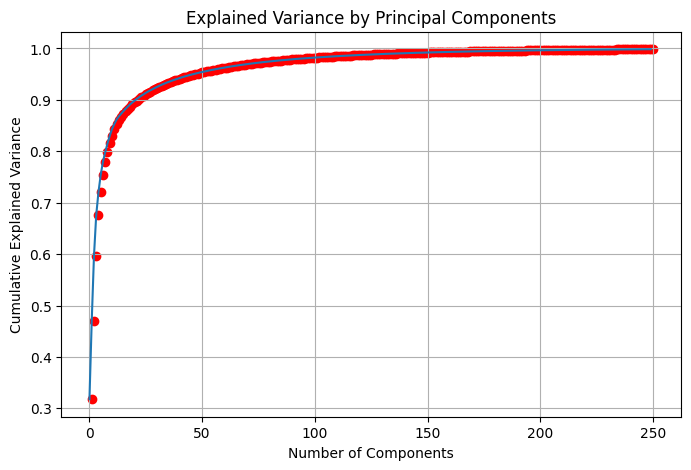

In [59]:
plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(explained_variance))
plt.scatter(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, color='r')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Principal Components')
plt.grid(True)
plt.show()

In [60]:
threshold = 0.95
num_components = np.argmax(cumulative_explained_variance >= threshold) + 1
print(f"Number of components needed to explain {threshold*100}% variance: {num_components}")


Number of components needed to explain 95.0% variance: 48


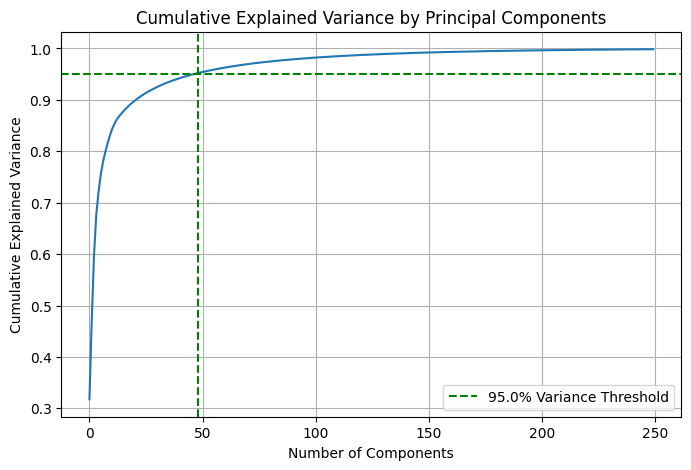

In [61]:
# Plot the cumulative explained variance
plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(explained_variance))
#plt.plot(cumulative_explained_variance, marker='o', linestyle='-', color='b', label='Cumulative Explained Variance')
#plt.scatter(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, color='r')
plt.axhline(y=threshold, color='g', linestyle='--', label=f'{threshold*100}% Variance Threshold')
plt.axvline(x=num_components, color='g', linestyle='--')

# Adding labels and title
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by Principal Components')
plt.grid(True)
plt.legend()
plt.show()

#### PCA dimension reduction magic number is 48

In [38]:
# function which takes embeddings and performs PCA with 48 dimensions

In [11]:
occupation_embeddings = pd.read_csv('/work/datascience_exam/data/occupation_embeddings.csv', index_col=0)
occupation_embeddings = occupation_embeddings.to_numpy()

In [62]:
def dimension_reduction_comp(embedded_data, components, X_train_data):
    total_variance_explained = []

    pca = PCA(n_components=components, random_state=42)

    pca_vecs = pca.fit_transform(embedded_data)

    explained_variance = pca.explained_variance_ratio_
    
    # Calculate the total variance explained by the specified number of components
    total_variance_explained = np.sum(explained_variance) * 100
    print(f"Total variance explained by the first {components} components: {total_variance_explained:.2f}%")

    #X_train_w_pca_vecs =np.empty(shape = (515049, 1))
    full_data = np.hstack((X_train_data, pca_vecs))
    
    return(full_data, pca_vecs)

In [63]:
X_train_w_pca_vecs, pca_vecs = dimension_reduction_comp(occupation_embeddings, 48, X_train_w_clusters)

Total variance explained by the first 48 components: 95.10%


In [64]:
pca_vecs.shape
# try clustering on pca_vecs!!! might be better now that it has 48 dimensions and not 250

(515049, 48)

In [35]:
X_train_w_clusters[:,4]

array([0, 2, 5, ..., 2, 5, 1], dtype=object)

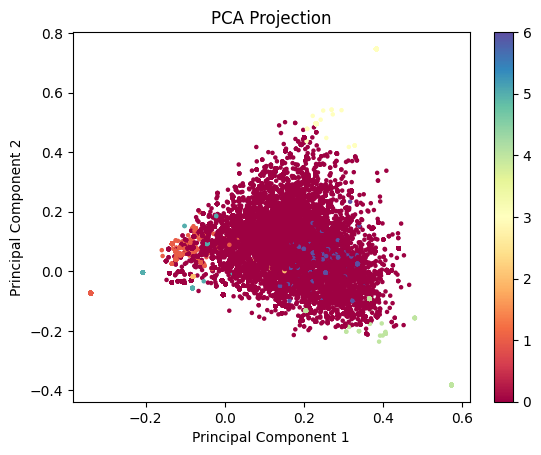

In [37]:
# Assuming 'labels' are your class labels or cluster assignments
plt.scatter(pca_vecs[:, 0], pca_vecs[:, 1], c=X_train_w_clusters[:,4], cmap='Spectral', s=5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Projection')
plt.colorbar()
plt.show()

In [ ]:
# Perform clustering on the reduced data
kmeans = KMeans(n_clusters=7)
cluster_labels = kmeans.fit_predict(pca_vecs)

# Calculate silhouette score
silhouette_avg = silhouette_score(pca_vecs, cluster_labels)
print(f"Silhouette Score: {silhouette_avg}")

In [ ]:
# last thing to try: visually inspect clusters after pca_vectors have been made 

#### Investigating the reconstruction error of the PCA

In [49]:
# Quality checking PCA vecs by calculating the reconstruction error
n_components = 48
pca = PCA(n_components=n_components, random_state=42)

# pca_vecs have already been made.- try to make them again
pca_vecs = pca.fit_transform(occupation_embeddings)

pca.components_

# reconstruct reduced data
reconstructed_data = pca.inverse_transform(pca_vecs) # doesn't work for some reason

# Calculate reconstruction error (mean squared error, MSE)
reconstruction_error = np.mean((occupation_embeddings - reconstructed_data) ** 2)
#print(f"Reconstruction Error: {reconstruction_error}")
print(f"Reconstruction Error: {reconstruction_error: .10f}") # without scientific notation 


Reconstruction Error: 7.018147822719225e-05


very low number. I'll allow it :-)

In [5]:
### saving pca_Vecs with clusters for occuption
pca_vecs

NameError: name 'pca_vecs' is not defined

##### Pairwise distance preservation

In [51]:
from scipy.spatial.distance import pdist, squareform

# Calculate pairwise distances in the original and reduced spaces
original_distances = pdist(occupation_embeddings)
reduced_distances = pdist(pca_vecs)

# Compute the correlation between original and reduced distances
correlation = np.corrcoef(original_distances, reduced_distances)[0, 1]
print(f"Correlation between Original and Reduced Pairwise Distances: {correlation}")


: 

## other stuff

In [38]:
X_train_w_pca_vecs[5,0:8] # checking out the array

array([1, 'France', 'journalist', 1879, 3, -0.2822265326976776,
       -0.005206998437643051, 0.20559027791023254], dtype=object)

In [40]:
# save 
np.save('/work/datascience_exam/data/oc_pca_train.npy', X_train_w_pca_vecs)

In [42]:
#X_train_w_pca= np.load('/work/datascience_exam/data/oc_pca_train.npy', allow_pickle=True)

### Clustering the PCA vectors - skip if done already

/var/folders/b0/t62rjb510wb79fxb5ch9n3kc0000gn/T/ipykernel_18139/4113629638.py:10: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo-" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(K, inertia, 'bo-', marker='o')


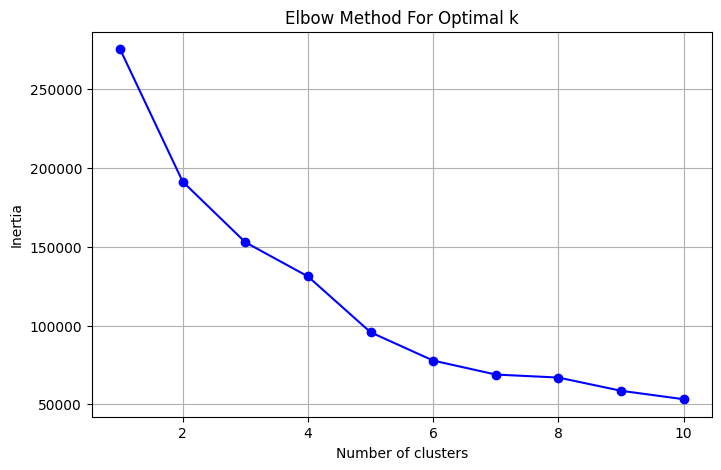

In [415]:

# Elbow Method to find the optimal number of clusters
inertia = []
K = range(1, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42).fit(pca_vecs)
    inertia.append(kmeans.inertia_)

# Plotting the results
plt.figure(figsize=(8, 5))
plt.plot(K, inertia, 'bo-', marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.grid(True)
plt.show()

In [416]:
# sample dataset (or reduce number of rows for testing code)
pca_vecs_subset = pca_vecs[:1000,:]
pca_vecs_subset.shape


(1000, 250)

/var/folders/b0/t62rjb510wb79fxb5ch9n3kc0000gn/T/ipykernel_18139/3401238058.py:13: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo-" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(K, silhouette_avg, 'bo-', marker='o')


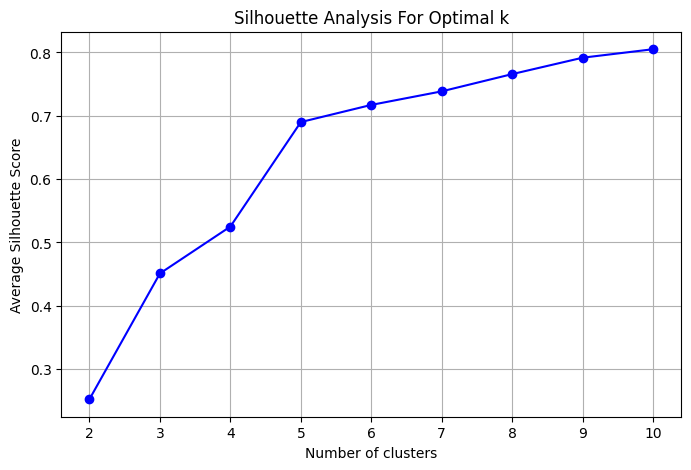

In [417]:
from sklearn.metrics import silhouette_score

# Silhouette Analysis to find the optimal number of clusters
silhouette_avg = []
K = range(2, 11)  # Silhouette score is not defined for k=1
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42).fit(pca_vecs_subset)
    cluster_labels = kmeans.labels_
    silhouette_avg.append(silhouette_score(pca_vecs_subset, cluster_labels))

# Plotting the results
plt.figure(figsize=(8, 5))
plt.plot(K, silhouette_avg, 'bo-', marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Average Silhouette Score')
plt.title('Silhouette Analysis For Optimal k')
plt.grid(True)
plt.show()


From chat: Running silhouette analysis can be computationally intensive, especially for larger datasets or a high range of cluster numbers. If your code is taking an unusually long time, it could be due to the following reasons:

- Large Dataset: If your dataset is very large, the silhouette score calculation will take longer.
- High Dimensionality: High-dimensional data can increase computational complexity.
- Number of Clusters Tested: Testing a large range of cluster numbers (e.g., from 2 to 100 or more) can significantly increase the runtime.

To identify potential issues and optimize the code, here are some steps you can take:

- Reduce the Range of Clusters: Start with a smaller range of clusters to see if the analysis completes in a reasonable time.
- Sample the Data: Use a smaller sample of your dataset to get an initial estimate.
- Check for Errors: Ensure there are no logical errors in the loop or the data being passed to the clustering algorithm.

5 clusters might be the way to go.

In [418]:
kmeans_oc = cluster.KMeans(n_clusters=5, random_state=42)
kmeans_oc.fit(pca_vecs)

clusters_oc = kmeans_oc.labels_
clusters_oc_reshaped = clusters_oc.reshape(-1, 1)

X_train_w_oc_clusters =  np.hstack((X_train, clusters_oc_reshaped))

KMeans(n_clusters=5, random_state=42)

In [421]:
X_train_w_oc_clusters

array([[1, 'Germany', 'researcher', 1829, 4],
       [1, 'United States of America', 'athlete', 1935, 0],
       [1, 'United Kingdom', 'artist', 1954, 1],
       ...,
       [1, 'United Kingdom', 'athlete', 1928, 0],
       [1, 'United States of America', 'politician', 1840, 2],
       [1, 'Austria-Hungary', 'artist', 1849, 1]], dtype=object)

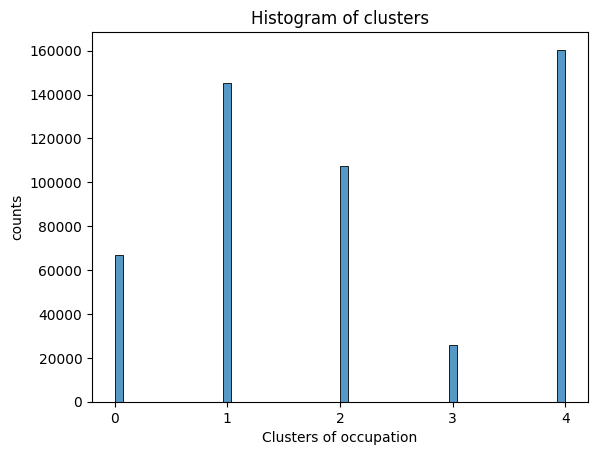

In [424]:
sns.histplot(X_train_w_oc_clusters[:,4])
plt.xlabel('Clusters of occupation')
plt.ylabel('counts')
plt.title('Histogram of clusters')
plt.xticks([0,1,2,3,4])
plt.show()

# Quick and dirty analysis - can I predict age of death by using the predictors of: gender, occupation_clusters, and birth_year? 

In [44]:
X_train_w_pca_vecs[4,0:9]

array([1, 'United States of America', 'architect', 1888, 0,
       0.08846291154623032, -0.012277638539671898, 0.2551773488521576,
       -0.004899174440652132], dtype=object)

In [45]:
X_train_gender = X_train_w_pca_vecs[:,0]

In [46]:
X_train_predictors = X_train_w_pca_vecs[:,3:]

In [47]:
# merge
X_train_predictors = np.hstack((X_train_gender.reshape(-1,1), X_train_predictors))

In [48]:
X_train_predictors

array([[1, 1802, 0, ..., -0.006425196770578623, 0.011249436065554619,
        0.004026276990771294],
       [2, 1884, 3, ..., -0.004694965668022633, 0.00615534745156765,
        0.03811401128768921],
       [1, 1896, 2, ..., -0.009284169413149357, 0.007633041124790907,
        0.000980375916697085],
       ...,
       [1, 1876, 3, ..., -5.700847759726457e-05, 0.00016401337052229792,
        0.00017116758681368083],
       [1, 1928, 2, ..., 0.00018319896480534226, -0.0005523464642465115,
        0.00030117304413579404],
       [1, 1860, 1, ..., -1.9409502783673815e-05, 7.097233174135908e-05,
        -0.001332309446297586]], dtype=object)

#### reloading data / saving data

In [647]:
#train = pd.read_csv('data/train.csv', index_col=0)

In [62]:
np.save("data/train_embedded", X_train_predictors, allow_pickle=True)

In [64]:
test = np.load("data/train_embedded.npy", allow_pickle=True)

## trying to build dummy, base and full model (full model will be tested using both KNN linear regressiona and??)

In [67]:

from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score

#MSE? yes?

### How to do this:
- Only use test data set

Models to build:
- a dummy model: mean of y
- a baseline model: using only gender? 
- full model:
    - a simple linear regression
    - a non-parametric linear regression KNN
    - a simple decision tree

All? or only the full models should be trained using CV and should be heavily regularized (_standardize_ first?). 
All models should be compared using the same error metric: mean squarred error 

choosing the best model, validate it, and then test it:
- investigate interpretability, feature importance, etc. 


In [68]:
performances = []

In [69]:
y_train.shape
X_train_predictors.shape

(515049, 51)

In [70]:
### Dummy model  -  mean of y

mean_value = y_train.mean()
model_name = 'dummy'
performance = np.sqrt(mean_squared_error(y_train, [mean_value]*y_train.shape[0]))
r2 = r2_score(y_train, [mean_value]*y_train.shape[0])
performances.append({'model': model_name,
                     'split': 'train',
                     'rmse': performance.round(4),
                     'r2': r2.round(4)})



In [71]:
### Baseline model - only predictor is gender - linear regression

gender = X_train_predictors[:,0].reshape(-1,1)
#gender = gender.reshape(-1,1)
reg = LinearRegression().fit(gender, y_train)

preds =  reg.predict(gender)
r2 = r2_score(y_train, preds)
performance = np.sqrt(mean_squared_error(y_train, preds))
performances.append({'model': 'linear-gender',
                         'rmse': performance.round(4),
                         'r2': r2.round(4)})


In [72]:
# standardize embedded data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_pred_scaled = scaler.fit_transform(X_train_predictors[:,3:])

In [73]:
non_scaled_cols = X_train_predictors[:,:3]
#X_train_pred_scaled.shape

In [74]:
X_train_predictors_scaled = np.hstack((non_scaled_cols, X_train_pred_scaled))

In [76]:
### full linear model 
# cv? - this is not working out 
# regularization? 

reg = LinearRegression().fit(X_train_predictors_scaled, y_train)

preds =  reg.predict(X_train_predictors_scaled)
r2 = r2_score(y_train, preds)
performance = np.sqrt(mean_squared_error(y_train, preds))
performances.append({'model': 'linear-full-scaled',
                         'rmse': performance.round(4),
                         'r2': r2.round(4)})



In [78]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LinearRegression

# Initialize the model
model = LinearRegression()

# Define the cross-validation strategy
kf = KFold(n_splits=5, shuffle=True, random_state=1)  # 5-fold cross-validation

# Perform cross-validation with RMSE as the scoring metric
scores = cross_val_score(model, X_train_predictors_scaled, y_train, cv=kf, scoring='neg_root_mean_squared_error')

# Calculate the average RMSE and standard deviation
rmse_scores = -scores  # Convert negative RMSE scores to positive
#print(f"Mean RMSE: {rmse_scores:.2f}") #, Standard Deviation of RMSE: {std_rmse:.2f}")



In [79]:
model_fit = model.fit(X_train_predictors_scaled, y_train)

preds =  model_fit.predict(X_train_predictors_scaled)
r2 = r2_score(y_train, preds)
performance = np.sqrt(mean_squared_error(y_train, preds))
performances.append({'model': 'linear-full-scaled-cv',
                         'rmse': performance.round(4),
                         'r2': r2.round(4)})

In [80]:
performances

[{'model': 'dummy', 'split': 'train', 'rmse': 15.9491, 'r2': 0.0},
 {'model': 'linear-gender', 'rmse': 15.9302, 'r2': 0.0024},
 {'model': 'linear-full-scaled', 'rmse': 15.5674, 'r2': 0.0473},
 {'model': 'linear-full-scaled-cv', 'rmse': 15.5674, 'r2': 0.0473}]

In [81]:
### full model but using polynomial linear regression
from sklearn.preprocessing import PolynomialFeatures

X_train_copy = X_train_predictors_scaled.copy()

poly = PolynomialFeatures(2)

X_train_copy = poly.fit_transform(X_train_copy)
reg = LinearRegression().fit(X_train_copy, y_train)
preds = reg.predict(X_train_copy)
r2 = r2_score(y_train, preds)
performance = np.sqrt(mean_squared_error(y_train, preds))
performances.append({'model': 'poly-allpreds-3',
                    'split': 'train',
                    'rmse': performance.round(4),
                    'r2': r2.round(4)})
       

In [82]:
performances

[{'model': 'dummy', 'split': 'train', 'rmse': 15.9491, 'r2': 0.0},
 {'model': 'linear-gender', 'rmse': 15.9302, 'r2': 0.0024},
 {'model': 'linear-full-scaled', 'rmse': 15.5674, 'r2': 0.0473},
 {'model': 'linear-full-scaled-cv', 'rmse': 15.5674, 'r2': 0.0473},
 {'model': 'poly-allpreds-3', 'split': 'train', 'rmse': 15.38, 'r2': 0.0701}]

In [84]:
from sklearn.neighbors import KNeighborsRegressor

In [86]:
# full model but using KNN linear regression

for k in [3,5,10,20,30]:
    neigh = KNeighborsRegressor(n_neighbors=k)
    neigh.fit(X_train_predictors, y_train)
    #pkl.dump(neigh, file=open(f'example-models/knn-allpreds-{k}.pkl', 'wb')) # save the model

    preds = neigh.predict(X_train_predictors)

    r2 = r2_score(y_train, preds)
    performance = np.sqrt(mean_squared_error(y_train, preds))
    performances.append({'model': f'knn-allpreds-{k}',
                            'split': 'train',
                            'rmse': performance.round(4),
                            'r2': r2.round(4)})

In [88]:
k = 100
neigh = KNeighborsRegressor(n_neighbors=k)
neigh.fit(X_train_predictors, y_train)
#pkl.dump(neigh, file=open(f'example-models/knn-allpreds-{k}.pkl', 'wb')) # save the model

preds = neigh.predict(X_train_predictors)

r2 = r2_score(y_train, preds)
performance = np.sqrt(mean_squared_error(y_train, preds))
performances.append({'model': f'knn-allpreds-{k}',
                        'split': 'train',
                        'rmse': performance.round(4),
                        'r2': r2.round(4)})

In [93]:
performances

[{'model': 'dummy', 'split': 'train', 'rmse': 15.9491, 'r2': 0.0},
 {'model': 'linear-gender', 'rmse': 15.9302, 'r2': 0.0024},
 {'model': 'linear-full-scaled', 'rmse': 15.5674, 'r2': 0.0473},
 {'model': 'linear-full-scaled-cv', 'rmse': 15.5674, 'r2': 0.0473},
 {'model': 'poly-allpreds-3', 'split': 'train', 'rmse': 15.38, 'r2': 0.0701},
 {'model': 'knn-allpreds-3', 'split': 'train', 'rmse': 15.6453, 'r2': 0.0377},
 {'model': 'knn-allpreds-5', 'split': 'train', 'rmse': 15.0149, 'r2': 0.1137},
 {'model': 'knn-allpreds-10', 'split': 'train', 'rmse': 14.5352, 'r2': 0.1694},
 {'model': 'knn-allpreds-20', 'split': 'train', 'rmse': 14.3129, 'r2': 0.1947},
 {'model': 'knn-allpreds-30', 'split': 'train', 'rmse': 14.2469, 'r2': 0.2021},
 {'model': 'knn-allpreds-100',
  'split': 'train',
  'rmse': 14.2103,
  'r2': 0.2062}]

In [92]:
## random forrest og feature importance 
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

In [95]:
rfreg = RandomForestRegressor(random_state=42) # first, we instantiate the estimator


In [96]:

param_grid = { 
    'n_estimators': [10, 20, 100, 200, 500],
    'max_depth' : [2, 3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'max_features': [0.3, 0.6, 0.9], # can you guess what this is, without looking at the documentation?
    'ccp_alpha': [0.01, 0.1, 1.0]
}

In [97]:
# cv
cv_rfr = RandomizedSearchCV(estimator=rfreg, # I am choosing RandomizedSearchCV for speed, but you can also go for GridSearchCV :)
                            param_distributions=param_grid,
                            scoring='neg_mean_squared_error', # this is "neg" because CV wants a metric to maximize
                            n_iter=20, # this should more likely be above 100, and in general the higher the better
                            cv=5)
cv_rfr.fit(X_train_predictors_scaled, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   n_iter=20,
                   param_distributions={'ccp_alpha': [0.01, 0.1, 1.0],
                                        'max_depth': [2, 3, 5, 10],
                                        'max_features': [0.3, 0.6, 0.9],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [10, 20, 100, 200,
                                                         500]},
                   scoring='neg_mean_squared_error')

In [99]:
cv_rfr.best_estimator_.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.01,
 'criterion': 'squared_error',
 'max_depth': 10,
 'max_features': 0.9,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 20,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [101]:
import pickle as pkl
random_forrest_model = cv_rfr.fit(X_train_predictors_scaled, y_train)


KeyboardInterrupt: 

In [ ]:
# save model 
pkl.dump(random_forrest_model, file=open(f'models/random_forrest.pkl', 'wb')) # save the model

In [121]:
model = cv_rfr.best_estimator_

preds = model.predict(X_train_predictors_scaled)
r2 = r2_score(y_train, preds)
performance = np.sqrt(mean_squared_error(y_train, preds))
performances.append({'model': 'random_forrest',
                         'split': 'train',
                         'rmse': performance.round(4),
                         'r2': r2.round(4)})

In [127]:
performances

[{'model': 'dummy', 'split': 'train', 'rmse': 15.9491, 'r2': 0.0},
 {'model': 'linear-gender', 'rmse': 15.9302, 'r2': 0.0024},
 {'model': 'linear-full-scaled', 'rmse': 15.5674, 'r2': 0.0473},
 {'model': 'linear-full-scaled-cv', 'rmse': 15.5674, 'r2': 0.0473},
 {'model': 'poly-allpreds-3', 'split': 'train', 'rmse': 15.38, 'r2': 0.0701},
 {'model': 'knn-allpreds-3', 'split': 'train', 'rmse': 15.6453, 'r2': 0.0377},
 {'model': 'knn-allpreds-5', 'split': 'train', 'rmse': 15.0149, 'r2': 0.1137},
 {'model': 'knn-allpreds-10', 'split': 'train', 'rmse': 14.5352, 'r2': 0.1694},
 {'model': 'knn-allpreds-20', 'split': 'train', 'rmse': 14.3129, 'r2': 0.1947},
 {'model': 'knn-allpreds-30', 'split': 'train', 'rmse': 14.2469, 'r2': 0.2021},
 {'model': 'knn-allpreds-100',
  'split': 'train',
  'rmse': 14.2103,
  'r2': 0.2062},
 {'model': 'random_forrest', 'split': 'train', 'rmse': 14.1089, 'r2': 0.2175}]

/var/folders/b0/t62rjb510wb79fxb5ch9n3kc0000gn/T/ipykernel_58583/1827935479.py:2: UserWarning: The palette list has more values (3) than needed (1), which may not be intended.
  sns.scatterplot(data=perf_df.sort_values(by='rmse', ascending=False),


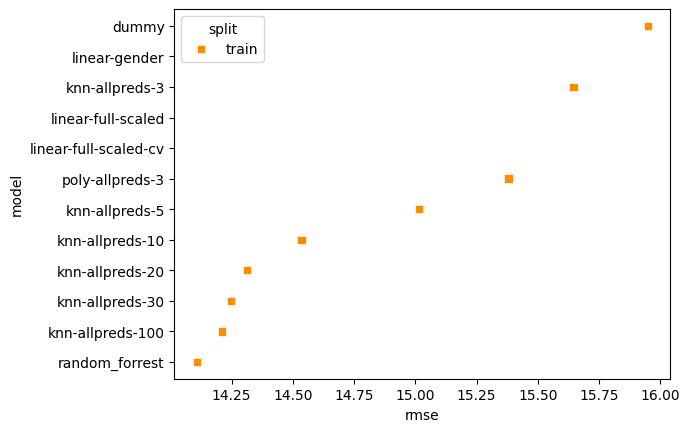

In [128]:
perf_df = pd.DataFrame(performances)
sns.scatterplot(data=perf_df.sort_values(by='rmse', ascending=False), 
                y='model', 
                x='rmse', 
                marker='s', 
                hue='split', palette=['darkorange', 'grey', 'darkred'])
plt.show()

In [ ]:
importances = cv_rfr.best_estimator_.feature_importances_
# the above computes the (normalized) total reduction of the criterion brought by that feature.


In [135]:
X_train_predictors_scaled

array([[1, 1802, 0, ..., -0.2554179293693479, 0.4493921567384053,
        0.1634051835715577],
       [2, 1884, 3, ..., -0.18687136405555144, 0.24389806248348778,
        1.5491458170337291],
       [1, 1896, 2, ..., -0.3686818480937487, 0.3035078074202907,
        0.03958267172358388],
       ...,
       [1, 1876, 3, ..., -0.0031294147827394046, 0.0022093397976395545,
        0.006686590866814162],
       [1, 1928, 2, ..., 0.00638688342458488, -0.026688413374974466,
        0.01197159582530955],
       [1, 1860, 1, ..., -0.0016398562035505957, -0.0015439093979730042,
        -0.05443302471431904]], dtype=object)

In [133]:
#train = pd.DataFrame(X_train_predictors_scaled, columns= ["Gender", "Birth yer", "Cluster_no" ""])

In [ ]:
train.columns.tolist()

In [139]:
X_train_predictors_scaled.shape

(515049, 51)

In [138]:
importances.shape

(51,)

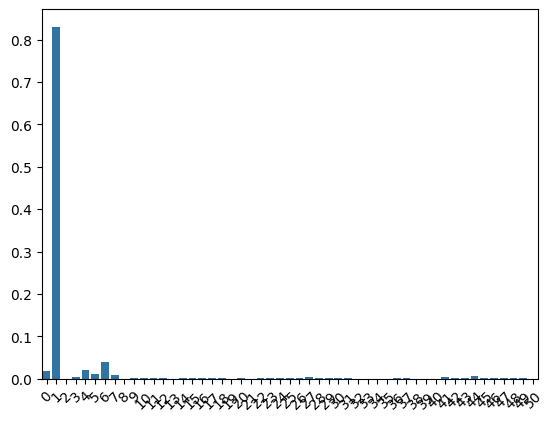

In [151]:
sns.barplot(x=train.columns.tolist(), y=importances, color=sns.color_palette()[0])
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
#plt.gca().set_xticks(plt.gca().get_xticks()[::2])  # Show every 10th tick # [::10]


plt.show()

### notes down

In [118]:
model1 = LinearRegression()
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
k = 5  # Number of splits
cv_scores = cross_val_score(model1, X_train_predictors, y_train, cv=k, scoring=mae_scorer)
mean_cv_score = -np.mean(cv_scores)  # Negate to get positive MAE
print(f"Mean Cross-Validation MAE: {mean_cv_score}")


Mean Cross-Validation MAE: 12.354561707753955


In [119]:
model1.fit(X_train_predictors, y_train)

LinearRegression()

In [120]:
y_pred = model1.predict(X_train_predictors)


KeyboardInterrupt: 

In [ ]:
mae_train = mean_absolute_error(y_train, y_pred)
mae_train

12.343469378464846

In [ ]:
y_train.mean()
y_train.std()

15.928885428768764

In [ ]:
# trying something

import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

# Assuming X and y are your predictors and target variable respectively
X = X_train_predictors
y = y_train

# Number of splits for cross-validation
k = 5

# Step 1: Create the linear regression model
model = LinearRegression()

# Step 2: Initialize KFold
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Lists to store the evaluation metrics for each fold
mae_scores = []

# Step 3: Perform cross-validation
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions on the validation set
    y_val_pred = model.predict(X_val)
    
    # Calculate the mean absolute error for the validation set
    mae = mean_absolute_error(y_val, y_val_pred)
    mae_scores.append(mae)

# Step 4: Calculate and print the mean cross-validation MAE
mean_cv_mae = np.mean(mae_scores)
print(f"Mean Cross-Validation MAE: {mean_cv_mae}")

IndexError: index 405330 is out of bounds for axis 0 with size 405330

# from here and down is mess

In [232]:
X_train_gender = X_train_w_oc_clusters[:,0]

In [234]:
X_train_gender.shape

(515049,)

In [238]:
X_train_gender_reshaped = X_train_gender.reshape(-1, 1)


In [239]:
X_train_gender_reshaped.shape

(515049, 1)

In [235]:
X_train_cluster_year = X_train_w_clusters[:,3:]

In [237]:
X_train_cluster_year

array([[1802, 1],
       [1884, 3],
       [1896, 1],
       ...,
       [1876, 1],
       [1928, 2],
       [1860, 2]], dtype=object)

In [240]:
X_train_w_oc_clusters_predictors = np.hstack((X_train_gender_reshaped, X_train_cluster_year))

In [241]:
X_train_w_oc_clusters_predictors

array([[1, 1802, 1],
       [2, 1884, 3],
       [1, 1896, 1],
       ...,
       [1, 1876, 1],
       [1, 1928, 2],
       [1, 1860, 2]], dtype=object)

In [223]:
y_train

array([51., 95., 70., ..., 68., 57., 42.])

In [226]:
model_linear_regression = LinearRegression()

In [242]:
model_linear_regression.fit(X_train_w_oc_clusters_predictors, y_train)

LinearRegression()

In [245]:
predictions = model_linear_regression.predict(X_train_w_oc_clusters_predictors)

In [247]:
print("Intercept:", model_linear_regression.intercept_)
print("Coefficient:", model_linear_regression.coef_)

# Print the predictions
print("Predictions:", predictions)

Intercept: 35.723330357451005
Coefficient: [ 2.23274723  0.01741172 -0.14764318]
Predictions: [69.18434782 72.54956944 70.82104919 ... 70.47281485 71.23058093
 70.0465842 ]


# Trying something else

In [256]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor

In [252]:

# PCA
pca = PCA(n_components=100)
reduced_embeddings = pca.fit_transform(occupation_embeddings)

# Assume embeddings is your array of text embeddings
kmeans = KMeans(n_clusters=5)
clusters_occupation = kmeans.fit_predict(reduced_embeddings)

# Use original embeddings plus cluster labels as features
features = np.hstack((reduced_embeddings, clusters_occupation.reshape(-1, 1)))


### the code below needs to incluce cross-validation! but not leave-one-out, K splits, maybe 10? 20? 

In [257]:
# Model training
model = RandomForestRegressor()
model.fit(features, y_train)

RandomForestRegressor()

In [ ]:
# compute MAE or something else

In [258]:
val = pd.read_csv(f"data/val.csv", index_col= 0)

In [266]:
y_val = val['Age of death']
X_val = val.drop(columns=['Age of death'])
X_val = X_val.drop(columns = ['Country'])

In [267]:
y_val.head()

0    58.0
1    79.0
2    79.0
3    73.0
4    82.0
Name: Age of death, dtype: float64

In [268]:
X_val.head()

,Gender_encode,Occupation,Birth year
0,1,Military personnel,1895
1,1,Researcher,1802
2,1,Artist,1902
3,1,Politician,1816
4,1,Artist,1811


In [260]:
predictions = model.predict(X_validation)

NameError: name 'X_validation' is not defined